In [1]:
## 第一阶段，先做movies与user的分级分布
import warnings
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
import gensim
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split

import gc
import random
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
##数据导入，只需要用到movies电影数据集和评分数据集
df_movies = pd.read_csv('./data/ml-20m/movies.csv')
df_ratings = pd.read_csv('./data/ml-20m/ratings.csv')
#将电影数据分别转换为id=>name，name=>id的映射字典
movieId_to_name = pd.Series(df_movies.title.values, index = df_movies.movieId.values).to_dict()
name_to_movieId = pd.Series(df_movies.movieId.values, index = df_movies.title.values).to_dict()

In [3]:
#随机打印5条记录在数据集里
for df in list((df_movies, df_ratings)):
    rand_idx = np.random.choice(len(df), 5, replace=False)
    display(df.iloc[rand_idx, :])
    print(f"Displaying 5 of the total {str(len(df))} data points")

,movieId,title,genres
23669,112586,Brothers (Veljekset) (2011),Drama
26667,128305,They All Lie (2009),Drama
3973,4067,Untamed Heart (1993),Drama|Romance
18415,91880,My Best Enemy (Mi mejor enemigo) (2005),Drama|War
25795,122218,The Sky Dragon (1949),Adventure|Comedy|Crime|Mystery|Thriller


Displaying 5 of the total 27278 data points


,userId,movieId,rating,timestamp
5132461,35132,63082,4.5,1350248952
13187804,91120,1037,2.5,1194904855
5639561,38818,350,5.0,843260140
16149444,111787,2001,3.5,1259732578
10528966,72840,5065,3.0,1023922604


Displaying 5 of the total 20000263 data points


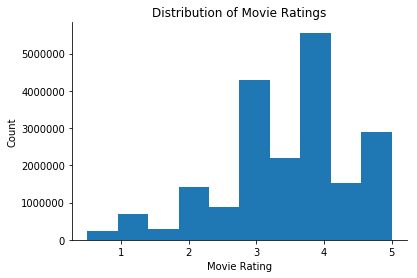

In [4]:
##分析数据阶段

plt.figure(figsize=(6, 4))
ax = plt.subplot(111)

ax.set_title("Distribution of Movie Ratings")
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
plt.xlabel("Movie Rating")
plt.ylabel("Count")
plt.hist(df_ratings['rating'])

plt.show()

In [5]:
##数据集切分
start = datetime.datetime.now()

df_ratings_train, df_ratings_test = train_test_split(df_ratings,
                                                    stratify=df_ratings['userId'], #按userID分布做划分
                                                    random_state=1234,
                                                    test_size=0.30)

print(f"Number of rating data: {str(len(df_ratings_train))}")
print(f"Number of test data: {str(len(df_ratings_test))}")

print(f"Time passed: {str(datetime.datetime.now() - start)}")

Number of rating data: 14000184
Number of test data: 6000079
Time passed: 0:00:10.912642


In [6]:
##构建item序列，并根据分数来做类别划分，然后根据分组来确定最终的item序列
def rating_splitter(df):
    df['liked'] = np.where(df['rating'] >= 4, 1, 0) #输出0/1划分
    df['movieId'] = df['movieId'].astype('str')
    gp_user_like = df.groupby(['liked', 'userId'])
    
    return ([gp_user_like.get_group(gp)['movieId'].tolist() for gp in gp_user_like.groups])

In [7]:
start = datetime.datetime.now()

pd.options.mode.chained_assignment = None
splitted_movies = rating_splitter(df_ratings_train)

print(f"Time passed: {str(datetime.datetime.now() - start)}")

Time passed: 0:03:23.370394


In [8]:
##使用gensim的word2vec训练item2vec模型
for movie_list in splitted_movies:
    random.shuffle(movie_list)
    
start = datetime.datetime.now()

model = Word2Vec(sentences=splitted_movies, #迭代序列
                iter=5, #迭代次数
                min_count=4, #忽略词频，小于10的将被忽略掉
                size=32,  #训练后的向量维度
                workers=2,  #设置的线程数
                sg=1,  #训练模型的模型选择，1=skip-gram，0=CBOW
                hs=0,  #训练代价函数的选择
                negative=5,  #负采样
                window=5)  #当前词和预测词的最大间隔

print(f"Time passed: {str(datetime.datetime.now() - start)}")

Time passed: 0:05:01.332603


In [68]:
##保存模型，保存了所有模型相关的信息，隐藏权重，词汇频率和模型二叉树，保存为word2vec文本格式，不能追加训练
model.wv.save_word2vec_format("./model/item2vec_model_0315.bin", binary=True)
model.wv.save_word2vec_format("./model/item2vec_model_0315.txt", binary=False)
##保存模型,可以追加训练
model.save('./model/item2vec_model_0315.model')

##模型加载
# gensim.models.KeyedVectors.load_word2vec_format('XX.txt', binary=False)
# gensim.models.KeyedVectors.load_word2vec_format('XX.bin', binary=True)

##追加训练，只能使用model.save的文件,更新模型
# model_add = gensim.models.Word2Vec.load("XXX").train(more_sentences)

##模型评估
# model.accuracy("./model/accuracy_item2vec.txt")

In [10]:
def produce_list_of_movieId(list_of_movieName):
    list_of_movie_id = []
    for movieName in list_of_movieName:
        if movieName in name_to_movieId.keys():
            print(f"model:produce_list_of_movieId, movieName: "+ movieName)
            list_of_movie_id.append(str(name_to_movieId[movieName]))
    print(f"model:produce_list_of_movieId, list_of_movie_id:{list_of_movie_id}")
    return list_of_movie_id

def recommender(positive_list=None, negative_list=None, topn=20):
    recommend_movie_ls = []
    if positive_list:
        print(f"model:recommender, positive_list:{positive_list}")
        positive_list = produce_list_of_movieId(positive_list)
    if negative_list:
        print(f"model:recommender, negative_list:{negative_list}")
        negative_list = produce_list_of_movieId(negative_list)
    
    print(f"model:recommender, positive_list:{positive_list}")
    for movieId, prob in model.wv.most_similar_cosmul(positive=positive_list, negative=negative_list, topn=topn):
        recommend_movie_ls.append(movieId)
    return recommend_movie_ls

In [16]:
m_now="Toy Story 3 (2010)"
ls = recommender(positive_list=[m_now], topn=5)
print(f'Recommendation Result based on "{m_now}":')
display(df_movies[df_movies['movieId'].isin(ls)])

model:recommender, positive_list:['Toy Story 3 (2010)']
model:produce_list_of_movieId, movieName: Toy Story 3 (2010)
model:produce_list_of_movieId, list_of_movie_id:['78499']
model:recommender, positive_list:['78499']
Recommendation Result based on "Toy Story 3 (2010)":


,movieId,title,genres
12746,60069,WALL·E (2008),Adventure|Animation|Children|Romance|Sci-Fi
13767,68954,Up (2009),Adventure|Animation|Children|Drama
15031,76093,How to Train Your Dragon (2010),Adventure|Animation|Children|Fantasy|IMAX
15526,79091,Despicable Me (2010),Animation|Children|Comedy|Crime
17499,88125,Harry Potter and the Deathly Hallows: Part 2 (...,Action|Adventure|Drama|Fantasy|Mystery|IMAX


In [18]:
m_now="Transformers (2007)"
ls = recommender(positive_list=[m_now], topn=5)
print(f'Recommendation Result based on "{m_now}":')
display(df_movies[df_movies['movieId'].isin(ls)])

model:recommender, positive_list:['Transformers (2007)']
model:produce_list_of_movieId, movieName: Transformers (2007)
model:produce_list_of_movieId, list_of_movie_id:['53996']
model:recommender, positive_list:['53996']
Recommendation Result based on "Transformers (2007)":


,movieId,title,genres
11826,52722,Spider-Man 3 (2007),Action|Adventure|Sci-Fi|Thriller|IMAX
12261,56174,I Am Legend (2007),Action|Horror|Sci-Fi|Thriller|IMAX
12742,60040,"Incredible Hulk, The (2008)",Action|Sci-Fi
12747,60072,Wanted (2008),Action|Thriller
12748,60074,Hancock (2008),Action|Adventure|Comedy|Crime|Fantasy


In [19]:
m_now="2012 (2009)"
ls = recommender(positive_list=[m_now], topn=5)
print(f'Recommendation Result based on "{m_now}":')
display(df_movies[df_movies['movieId'].isin(ls)])

model:recommender, positive_list:['2012 (2009)']
model:produce_list_of_movieId, movieName: 2012 (2009)
model:produce_list_of_movieId, list_of_movie_id:['72378']
model:recommender, positive_list:['72378']
Recommendation Result based on "2012 (2009)":


,movieId,title,genres
13597,67799,The Butterfly Effect 3: Revelations (2009),Drama|Fantasy|Sci-Fi|Thriller
13608,67867,Dragonball Evolution (2009),Action|Adventure|Fantasy|Sci-Fi
13713,68554,Angels & Demons (2009),Crime|Drama|Mystery|Thriller
15397,78469,"A-Team, The (2010)",Action|Comedy|Thriller
16037,81180,30 Days of Night: Dark Days (2010),Horror|Thriller


In [20]:
m_now="Titanic (1997)"
ls = recommender(positive_list=[m_now], topn=5)
print(f'Recommendation Result based on "{m_now}":')
display(df_movies[df_movies['movieId'].isin(ls)])

model:recommender, positive_list:['Titanic (1997)']
model:produce_list_of_movieId, movieName: Titanic (1997)
model:produce_list_of_movieId, list_of_movie_id:['1721']
model:recommender, positive_list:['1721']
Recommendation Result based on "Titanic (1997)":


,movieId,title,genres
1625,1682,"Truman Show, The (1998)",Comedy|Drama|Sci-Fi
1645,1704,Good Will Hunting (1997),Drama|Romance
1713,1784,As Good as It Gets (1997),Comedy|Drama|Romance
1877,1961,Rain Man (1988),Drama
2183,2268,"Few Good Men, A (1992)",Crime|Drama|Thriller


In [22]:
m_now="Enemy at the Gates (2001)"
ls = recommender(positive_list=[m_now], topn=5)
print(f'Recommendation Result based on "{m_now}":')
display(df_movies[df_movies['movieId'].isin(ls)])

model:recommender, positive_list:['Enemy at the Gates (2001)']
model:produce_list_of_movieId, movieName: Enemy at the Gates (2001)
model:produce_list_of_movieId, list_of_movie_id:['4223']
model:recommender, positive_list:['4223']
Recommendation Result based on "Enemy at the Gates (2001)":


,movieId,title,genres
4680,4776,Training Day (2001),Crime|Drama|Thriller
4805,4901,Spy Game (2001),Action|Crime|Drama|Thriller
4914,5010,Black Hawk Down (2001),Action|Drama|War
5056,5152,We Were Soldiers (2002),Action|Drama|War
5367,5464,Road to Perdition (2002),Crime|Drama


In [39]:
###查看两个向量的相似度
print(model.wv.similarity(str(name_to_movieId['Rain Man (1988)']) , str(name_to_movieId['Truman Show, The (1998)'])))
print(model.wv.similarity(str(name_to_movieId['Rain Man (1988)']) , str(name_to_movieId['Up (2009)'])))
print(model.wv.similarity(str(name_to_movieId['Up (2009)']) , str(name_to_movieId['WALL·E (2008)'])))
print(model.wv.similarity(str(name_to_movieId['2012 (2009)']) , str(name_to_movieId['Enemy at the Gates (2001)'])))

0.8848135561852837
0.5666167598906688
0.9526461499087733
0.5014512812580174


In [54]:
#找出不同类的item
diff = model.wv.doesnt_match([str(name_to_movieId['Up (2009)']) , 
                                              str(name_to_movieId['WALL·E (2008)']),
                                              str(name_to_movieId['Despicable Me (2010)']),
                                              str(name_to_movieId['Rain Man (1988)'])])
df_movies[df_movies['movieId'].astype('str') == diff]

,movieId,title,genres
1877,1961,Rain Man (1988),Drama


In [74]:
##获取相关的向量
item_vector = model.wv['1234']
item_vector

array([ 0.05243643, -0.11525867, -0.3766339 ,  0.3468273 , -0.44353652,
       -0.7402054 , -0.03762453,  0.05154592,  0.02068542,  0.34640124,
       -0.36311376,  0.15405177,  0.09046546, -0.13065238, -0.43854085,
        0.24089494, -0.33191556, -0.32298008,  0.22842562, -0.05481716,
        0.41301683,  0.26706886, -0.61282545,  0.7585894 ,  0.13987756,
        0.34451604, -0.12170434, -0.4812016 ,  0.12808688,  0.01357524,
       -0.01181941, -0.23340093], dtype=float32)

In [75]:
df_ratings_test.head()

,userId,movieId,rating,timestamp
2864101,19410,1234,1.0,1005610477
115627,776,2018,4.0,962984793
19820967,137218,14,5.0,851035419
3667336,24976,2188,2.0,1015040676
19362844,134050,661,4.0,1140398554


In [77]:
splitted_movies[0]

['3932',
 '6807',
 '6242',
 '2804',
 '2644',
 '1304',
 '1208',
 '112',
 '1262',
 '2253',
 '6502',
 '3476',
 '8690',
 '6755',
 '6888',
 '1009',
 '1291',
 '367',
 '32',
 '2',
 '1920',
 '919',
 '589',
 '1246',
 '1994',
 '7001',
 '2918',
 '1217',
 '2716',
 '47',
 '1089',
 '653',
 '7482',
 '4980',
 '1261',
 '593',
 '2947',
 '3030',
 '1136',
 '3000',
 '4720',
 '1525',
 '7045',
 '3265',
 '4878',
 '4941',
 '2761',
 '924',
 '1201',
 '3037',
 '5898',
 '5146',
 '8482',
 '1080',
 '5679',
 '2664',
 '2692',
 '337',
 '6834',
 '1750']

In [91]:
df_test =df_ratings_test.iloc[:10000, :].groupby(['movieId', 'userId'])

In [94]:
for gp_t in df_test.groups:
    print(gp_t)
    print(df_test.get_group(gp_t)['userId'].tolist())

(1, 3572)
[3572]
(1, 8567)
[8567]
(1, 14116)
[14116]
(1, 16225)
[16225]
(1, 22428)
[22428]
(1, 30510)
[30510]
(1, 39452)
[39452]
(1, 41338)
[41338]
(1, 42726)
[42726]
(1, 45652)
[45652]
(1, 50772)
[50772]
(1, 58086)
[58086]
(1, 61694)
[61694]
(1, 81898)
[81898]
(1, 87526)
[87526]
(1, 88197)
[88197]
(1, 89791)
[89791]
(1, 94957)
[94957]
(1, 106113)
[106113]
(1, 115716)
[115716]
(1, 122014)
[122014]
(1, 122387)
[122387]
(1, 131519)
[131519]
(2, 12679)
[12679]
(2, 14841)
[14841]
(2, 24397)
[24397]
(2, 39939)
[39939]
(2, 41816)
[41816]
(2, 43482)
[43482]
(2, 52898)
[52898]
(2, 72266)
[72266]
(2, 82825)
[82825]
(2, 91378)
[91378]
(2, 97455)
[97455]
(2, 100101)
[100101]
(3, 17687)
[17687]
(3, 35025)
[35025]
(3, 39723)
[39723]
(3, 97181)
[97181]
(5, 29744)
[29744]
(5, 39351)
[39351]
(5, 102941)
[102941]
(6, 1126)
[1126]
(6, 5636)
[5636]
(6, 42692)
[42692]
(6, 43459)
[43459]
(6, 56241)
[56241]
(6, 121564)
[121564]
(6, 135298)
[135298]
(7, 16452)
[16452]
(7, 54212)
[54212]
(7, 73454)
[73454]
(7

[66208]
(110, 77987)
[77987]
(110, 79009)
[79009]
(110, 87537)
[87537]
(110, 88254)
[88254]
(110, 88683)
[88683]
(110, 89124)
[89124]
(110, 107849)
[107849]
(110, 116570)
[116570]
(110, 116590)
[116590]
(110, 117154)
[117154]
(110, 127063)
[127063]
(110, 128285)
[128285]
(110, 130518)
[130518]
(110, 135311)
[135311]
(110, 138056)
[138056]
(111, 1359)
[1359]
(111, 13922)
[13922]
(111, 16756)
[16756]
(111, 22063)
[22063]
(111, 38228)
[38228]
(111, 38573)
[38573]
(111, 45423)
[45423]
(111, 51085)
[51085]
(111, 62503)
[62503]
(111, 67490)
[67490]
(111, 125022)
[125022]
(111, 131221)
[131221]
(111, 132562)
[132562]
(111, 137807)
[137807]
(112, 10462)
[10462]
(112, 26180)
[26180]
(112, 30333)
[30333]
(112, 49580)
[49580]
(112, 67443)
[67443]
(112, 74447)
[74447]
(112, 82869)
[82869]
(112, 107009)
[107009]
(112, 120820)
[120820]
(112, 126645)
[126645]
(112, 131275)
[131275]
(112, 137365)
[137365]
(113, 121212)
[121212]
(117, 1908)
[1908]
(118, 104652)
[104652]
(121, 71135)
[71135]
(122, 30098

(365, 34185)
[34185]
(365, 40536)
[40536]
(366, 26166)
[26166]
(367, 15278)
[15278]
(367, 19897)
[19897]
(367, 24365)
[24365]
(367, 35265)
[35265]
(367, 51494)
[51494]
(367, 53113)
[53113]
(367, 71388)
[71388]
(367, 76000)
[76000]
(367, 83580)
[83580]
(367, 86830)
[86830]
(367, 103868)
[103868]
(367, 108884)
[108884]
(367, 113406)
[113406]
(367, 120133)
[120133]
(367, 124113)
[124113]
(367, 124511)
[124511]
(367, 137701)
[137701]
(368, 40995)
[40995]
(368, 45986)
[45986]
(368, 61352)
[61352]
(368, 65999)
[65999]
(368, 87534)
[87534]
(368, 121727)
[121727]
(368, 123719)
[123719]
(368, 124622)
[124622]
(368, 137993)
[137993]
(369, 31092)
[31092]
(370, 11148)
[11148]
(370, 11900)
[11900]
(370, 23009)
[23009]
(370, 45750)
[45750]
(370, 86592)
[86592]
(370, 132153)
[132153]
(371, 12986)
[12986]
(371, 104533)
[104533]
(372, 671)
[671]
(372, 39089)
[39089]
(372, 77144)
[77144]
(372, 95010)
[95010]
(372, 133686)
[133686]
(373, 22357)
[22357]
(373, 53769)
[53769]
(373, 54533)
[54533]
(373, 5596

[88138]
(500, 98001)
[98001]
(500, 99516)
[99516]
(500, 103317)
[103317]
(500, 114151)
[114151]
(500, 124651)
[124651]
(501, 17303)
[17303]
(501, 117777)
[117777]
(502, 56309)
[56309]
(502, 99169)
[99169]
(502, 100269)
[100269]
(502, 104235)
[104235]
(505, 68796)
[68796]
(507, 10435)
[10435]
(507, 103690)
[103690]
(508, 13117)
[13117]
(508, 18280)
[18280]
(508, 24921)
[24921]
(508, 26527)
[26527]
(508, 29119)
[29119]
(508, 46121)
[46121]
(508, 59667)
[59667]
(508, 81508)
[81508]
(508, 113400)
[113400]
(508, 114534)
[114534]
(508, 115268)
[115268]
(508, 129146)
[129146]
(508, 129701)
[129701]
(508, 131167)
[131167]
(509, 48)
[48]
(509, 83147)
[83147]
(509, 86647)
[86647]
(509, 98583)
[98583]
(511, 91261)
[91261]
(512, 88645)
[88645]
(514, 10164)
[10164]
(514, 39291)
[39291]
(514, 58742)
[58742]
(514, 76044)
[76044]
(515, 12668)
[12668]
(515, 35137)
[35137]
(515, 56597)
[56597]
(515, 83483)
[83483]
(517, 33974)
[33974]
(517, 34557)
[34557]
(517, 93152)
[93152]
(519, 3586)
[3586]
(519, 41

[22620]
(595, 34526)
[34526]
(595, 41536)
[41536]
(595, 42616)
[42616]
(595, 55820)
[55820]
(595, 59115)
[59115]
(595, 63146)
[63146]
(595, 84392)
[84392]
(595, 84516)
[84516]
(595, 84860)
[84860]
(595, 126229)
[126229]
(595, 128920)
[128920]
(595, 129150)
[129150]
(595, 138019)
[138019]
(596, 648)
[648]
(596, 31911)
[31911]
(596, 104803)
[104803]
(596, 128315)
[128315]
(597, 17061)
[17061]
(597, 25315)
[25315]
(597, 26197)
[26197]
(597, 43675)
[43675]
(597, 48347)
[48347]
(597, 48405)
[48405]
(597, 52463)
[52463]
(597, 65415)
[65415]
(597, 76529)
[76529]
(597, 76859)
[76859]
(597, 83382)
[83382]
(597, 84395)
[84395]
(597, 85529)
[85529]
(597, 101788)
[101788]
(597, 101939)
[101939]
(597, 105722)
[105722]
(597, 122744)
[122744]
(597, 127895)
[127895]
(597, 128755)
[128755]
(597, 130584)
[130584]
(597, 136380)
[136380]
(599, 25129)
[25129]
(600, 67181)
[67181]
(605, 21826)
[21826]
(605, 29335)
[29335]
(605, 30768)
[30768]
(605, 65706)
[65706]
(608, 62)
[62]
(608, 672)
[672]
(608, 6446)


[71036]
(1023, 123799)
[123799]
(1023, 130602)
[130602]
(1025, 22678)
[22678]
(1025, 99572)
[99572]
(1025, 106753)
[106753]
(1027, 13124)
[13124]
(1027, 18765)
[18765]
(1027, 23184)
[23184]
(1028, 1001)
[1001]
(1028, 2950)
[2950]
(1028, 24718)
[24718]
(1028, 116974)
[116974]
(1028, 119963)
[119963]
(1029, 1810)
[1810]
(1029, 23664)
[23664]
(1029, 116684)
[116684]
(1029, 134847)
[134847]
(1030, 17143)
[17143]
(1032, 6476)
[6476]
(1032, 11165)
[11165]
(1032, 113336)
[113336]
(1032, 123337)
[123337]
(1035, 24269)
[24269]
(1035, 27242)
[27242]
(1035, 32164)
[32164]
(1035, 86156)
[86156]
(1035, 88969)
[88969]
(1036, 488)
[488]
(1036, 8719)
[8719]
(1036, 13610)
[13610]
(1036, 15532)
[15532]
(1036, 26345)
[26345]
(1036, 32347)
[32347]
(1036, 77518)
[77518]
(1036, 101715)
[101715]
(1036, 105023)
[105023]
(1036, 105667)
[105667]
(1036, 115592)
[115592]
(1036, 116567)
[116567]
(1036, 131624)
[131624]
(1037, 99313)
[99313]
(1037, 136780)
[136780]
(1041, 137155)
[137155]
(1042, 3877)
[3877]
(1042,

(1204, 55595)
[55595]
(1204, 63502)
[63502]
(1204, 80492)
[80492]
(1204, 99643)
[99643]
(1204, 120800)
[120800]
(1206, 9995)
[9995]
(1206, 26251)
[26251]
(1206, 37695)
[37695]
(1206, 63271)
[63271]
(1206, 89073)
[89073]
(1206, 93290)
[93290]
(1206, 95092)
[95092]
(1206, 101275)
[101275]
(1206, 121279)
[121279]
(1207, 20179)
[20179]
(1207, 36329)
[36329]
(1207, 93560)
[93560]
(1207, 97285)
[97285]
(1207, 98947)
[98947]
(1207, 104227)
[104227]
(1207, 117059)
[117059]
(1207, 126588)
[126588]
(1207, 137530)
[137530]
(1208, 56963)
[56963]
(1208, 59141)
[59141]
(1208, 84160)
[84160]
(1208, 88604)
[88604]
(1208, 116188)
[116188]
(1208, 122758)
[122758]
(1208, 133403)
[133403]
(1209, 11990)
[11990]
(1209, 97559)
[97559]
(1210, 2440)
[2440]
(1210, 7744)
[7744]
(1210, 20967)
[20967]
(1210, 22888)
[22888]
(1210, 36481)
[36481]
(1210, 38594)
[38594]
(1210, 46424)
[46424]
(1210, 48553)
[48553]
(1210, 63911)
[63911]
(1210, 74659)
[74659]
(1210, 75431)
[75431]
(1210, 75847)
[75847]
(1210, 81155)
[811

(1408, 614)
[614]
(1408, 25807)
[25807]
(1408, 47101)
[47101]
(1408, 49809)
[49809]
(1408, 63039)
[63039]
(1408, 71368)
[71368]
(1408, 83174)
[83174]
(1408, 93995)
[93995]
(1408, 137223)
[137223]
(1409, 4545)
[4545]
(1411, 84029)
[84029]
(1411, 107214)
[107214]
(1411, 131180)
[131180]
(1411, 134393)
[134393]
(1416, 60119)
[60119]
(1416, 94837)
[94837]
(1419, 70446)
[70446]
(1419, 71760)
[71760]
(1422, 72368)
[72368]
(1425, 4681)
[4681]
(1425, 35128)
[35128]
(1425, 46449)
[46449]
(1427, 124721)
[124721]
(1429, 9953)
[9953]
(1429, 66226)
[66226]
(1429, 88858)
[88858]
(1431, 24077)
[24077]
(1431, 136155)
[136155]
(1436, 101110)
[101110]
(1438, 21185)
[21185]
(1438, 37296)
[37296]
(1438, 48072)
[48072]
(1438, 101081)
[101081]
(1441, 9116)
[9116]
(1441, 25296)
[25296]
(1441, 27853)
[27853]
(1441, 136794)
[136794]
(1444, 68039)
[68039]
(1445, 55128)
[55128]
(1446, 107897)
[107897]
(1447, 46470)
[46470]
(1449, 34584)
[34584]
(1449, 81786)
[81786]
(1449, 88604)
[88604]
(1456, 109124)
[109124]


[94011]
(1748, 110591)
[110591]
(1752, 47451)
[47451]
(1753, 68803)
[68803]
(1753, 96538)
[96538]
(1754, 105588)
[105588]
(1754, 109272)
[109272]
(1756, 116587)
[116587]
(1760, 66650)
[66650]
(1760, 105281)
[105281]
(1769, 67303)
[67303]
(1772, 28093)
[28093]
(1772, 69023)
[69023]
(1772, 93573)
[93573]
(1777, 11348)
[11348]
(1777, 21132)
[21132]
(1777, 55486)
[55486]
(1777, 134399)
[134399]
(1779, 8541)
[8541]
(1779, 91245)
[91245]
(1779, 98924)
[98924]
(1779, 114453)
[114453]
(1780, 69937)
[69937]
(1783, 110388)
[110388]
(1784, 1802)
[1802]
(1784, 11228)
[11228]
(1784, 15822)
[15822]
(1784, 15872)
[15872]
(1784, 22760)
[22760]
(1784, 29153)
[29153]
(1784, 33092)
[33092]
(1784, 39970)
[39970]
(1784, 50579)
[50579]
(1784, 70883)
[70883]
(1784, 75077)
[75077]
(1784, 76446)
[76446]
(1784, 89075)
[89075]
(1784, 92915)
[92915]
(1784, 102034)
[102034]
(1784, 111210)
[111210]
(1784, 125927)
[125927]
(1784, 132322)
[132322]
(1784, 137143)
[137143]
(1788, 92518)
[92518]
(1791, 16606)
[16606]
(1

[111465]
(2076, 116982)
[116982]
(2078, 13569)
[13569]
(2078, 33476)
[33476]
(2078, 49386)
[49386]
(2078, 52321)
[52321]
(2078, 52845)
[52845]
(2078, 125940)
[125940]
(2080, 21850)
[21850]
(2080, 57874)
[57874]
(2080, 74102)
[74102]
(2080, 87846)
[87846]
(2081, 55312)
[55312]
(2081, 58196)
[58196]
(2081, 117752)
[117752]
(2081, 132486)
[132486]
(2082, 27210)
[27210]
(2082, 127559)
[127559]
(2085, 26855)
[26855]
(2085, 58800)
[58800]
(2085, 100506)
[100506]
(2085, 116127)
[116127]
(2087, 78)
[78]
(2087, 28731)
[28731]
(2087, 40649)
[40649]
(2087, 57673)
[57673]
(2087, 80886)
[80886]
(2087, 101033)
[101033]
(2087, 104878)
[104878]
(2090, 79401)
[79401]
(2090, 136534)
[136534]
(2091, 99518)
[99518]
(2092, 32618)
[32618]
(2092, 136988)
[136988]
(2093, 196)
[196]
(2093, 4295)
[4295]
(2094, 22861)
[22861]
(2094, 28744)
[28744]
(2094, 30731)
[30731]
(2094, 53235)
[53235]
(2096, 6811)
[6811]
(2096, 22493)
[22493]
(2096, 66172)
[66172]
(2096, 98292)
[98292]
(2097, 96050)
[96050]
(2099, 134538)


[7699]
(2395, 9850)
[9850]
(2395, 19104)
[19104]
(2395, 19714)
[19714]
(2395, 47577)
[47577]
(2395, 65409)
[65409]
(2395, 80007)
[80007]
(2395, 81664)
[81664]
(2395, 110907)
[110907]
(2396, 1258)
[1258]
(2396, 15803)
[15803]
(2396, 36421)
[36421]
(2396, 45921)
[45921]
(2396, 79978)
[79978]
(2396, 85198)
[85198]
(2396, 92157)
[92157]
(2396, 95588)
[95588]
(2396, 100720)
[100720]
(2396, 132765)
[132765]
(2398, 7390)
[7390]
(2398, 59567)
[59567]
(2401, 41792)
[41792]
(2402, 24719)
[24719]
(2402, 98401)
[98401]
(2402, 129698)
[129698]
(2403, 68458)
[68458]
(2403, 96211)
[96211]
(2404, 10882)
[10882]
(2404, 55303)
[55303]
(2404, 78302)
[78302]
(2404, 97567)
[97567]
(2405, 58027)
[58027]
(2405, 96488)
[96488]
(2405, 128505)
[128505]
(2406, 10443)
[10443]
(2406, 11241)
[11241]
(2406, 26273)
[26273]
(2406, 34133)
[34133]
(2406, 96093)
[96093]
(2406, 106736)
[106736]
(2406, 107559)
[107559]
(2407, 2351)
[2351]
(2407, 56142)
[56142]
(2407, 60504)
[60504]
(2407, 80655)
[80655]
(2407, 103925)
[103

(2699, 78903)
[78903]
(2699, 81413)
[81413]
(2699, 104977)
[104977]
(2699, 106336)
[106336]
(2700, 9298)
[9298]
(2700, 22131)
[22131]
(2700, 38605)
[38605]
(2700, 39468)
[39468]
(2700, 80668)
[80668]
(2700, 98749)
[98749]
(2700, 122043)
[122043]
(2701, 33944)
[33944]
(2701, 34062)
[34062]
(2701, 54703)
[54703]
(2701, 86015)
[86015]
(2701, 95466)
[95466]
(2705, 59340)
[59340]
(2706, 13203)
[13203]
(2706, 18851)
[18851]
(2706, 24131)
[24131]
(2706, 36919)
[36919]
(2706, 101021)
[101021]
(2706, 128315)
[128315]
(2707, 49183)
[49183]
(2707, 71251)
[71251]
(2707, 81551)
[81551]
(2707, 82323)
[82323]
(2707, 90968)
[90968]
(2707, 121970)
[121970]
(2709, 26185)
[26185]
(2710, 1552)
[1552]
(2710, 48054)
[48054]
(2710, 52456)
[52456]
(2710, 72337)
[72337]
(2710, 83459)
[83459]
(2710, 91885)
[91885]
(2710, 102742)
[102742]
(2710, 127591)
[127591]
(2712, 11706)
[11706]
(2712, 19722)
[19722]
(2712, 27382)
[27382]
(2712, 42593)
[42593]
(2712, 43373)
[43373]
(2712, 65261)
[65261]
(2712, 66765)
[66765

[116430]
(3260, 31680)
[31680]
(3260, 69988)
[69988]
(3260, 107228)
[107228]
(3262, 58285)
[58285]
(3263, 106601)
[106601]
(3264, 19434)
[19434]
(3264, 71699)
[71699]
(3264, 121401)
[121401]
(3266, 126293)
[126293]
(3270, 39962)
[39962]
(3270, 40058)
[40058]
(3270, 93227)
[93227]
(3272, 77563)
[77563]
(3273, 61349)
[61349]
(3274, 136941)
[136941]
(3275, 6995)
[6995]
(3275, 49413)
[49413]
(3275, 58944)
[58944]
(3275, 116617)
[116617]
(3285, 53972)
[53972]
(3285, 77359)
[77359]
(3287, 90790)
[90790]
(3288, 3515)
[3515]
(3289, 12189)
[12189]
(3298, 72482)
[72482]
(3300, 422)
[422]
(3300, 11566)
[11566]
(3300, 49227)
[49227]
(3300, 84683)
[84683]
(3300, 86111)
[86111]
(3301, 22751)
[22751]
(3301, 67064)
[67064]
(3306, 58922)
[58922]
(3307, 77630)
[77630]
(3310, 114648)
[114648]
(3314, 77478)
[77478]
(3316, 46851)
[46851]
(3316, 85433)
[85433]
(3316, 100306)
[100306]
(3317, 347)
[347]
(3317, 18448)
[18448]
(3317, 26111)
[26111]
(3317, 50912)
[50912]
(3324, 122593)
[122593]
(3327, 43264)
[43

[83251]
(3717, 138330)
[138330]
(3723, 39741)
[39741]
(3730, 27691)
[27691]
(3733, 26860)
[26860]
(3733, 93285)
[93285]
(3735, 25874)
[25874]
(3735, 35761)
[35761]
(3735, 83120)
[83120]
(3735, 132491)
[132491]
(3736, 119048)
[119048]
(3740, 48815)
[48815]
(3740, 88981)
[88981]
(3741, 50708)
[50708]
(3744, 41667)
[41667]
(3744, 125417)
[125417]
(3745, 7321)
[7321]
(3745, 59207)
[59207]
(3745, 71244)
[71244]
(3745, 113846)
[113846]
(3746, 76420)
[76420]
(3751, 10175)
[10175]
(3751, 44500)
[44500]
(3751, 60398)
[60398]
(3751, 89215)
[89215]
(3751, 95514)
[95514]
(3751, 100134)
[100134]
(3751, 124107)
[124107]
(3751, 129092)
[129092]
(3751, 135012)
[135012]
(3752, 57807)
[57807]
(3752, 89500)
[89500]
(3752, 121122)
[121122]
(3753, 19890)
[19890]
(3753, 44663)
[44663]
(3753, 86852)
[86852]
(3753, 109299)
[109299]
(3753, 114302)
[114302]
(3755, 14574)
[14574]
(3755, 21349)
[21349]
(3755, 27800)
[27800]
(3755, 27986)
[27986]
(3755, 31348)
[31348]
(3755, 47258)
[47258]
(3755, 48162)
[48162]
(3

(4857, 60374)
[60374]
(4857, 129793)
[129793]
(4864, 87030)
[87030]
(4865, 29738)
[29738]
(4865, 37534)
[37534]
(4865, 40020)
[40020]
(4865, 42956)
[42956]
(4865, 70141)
[70141]
(4865, 116868)
[116868]
(4866, 6030)
[6030]
(4866, 39937)
[39937]
(4873, 11813)
[11813]
(4873, 114185)
[114185]
(4874, 15964)
[15964]
(4878, 17503)
[17503]
(4878, 27958)
[27958]
(4878, 31884)
[31884]
(4878, 83024)
[83024]
(4878, 100349)
[100349]
(4878, 102211)
[102211]
(4878, 102845)
[102845]
(4878, 106519)
[106519]
(4878, 112801)
[112801]
(4880, 84154)
[84154]
(4881, 107266)
[107266]
(4885, 1815)
[1815]
(4886, 5338)
[5338]
(4886, 17502)
[17502]
(4886, 29916)
[29916]
(4886, 38881)
[38881]
(4886, 59198)
[59198]
(4886, 60510)
[60510]
(4886, 73478)
[73478]
(4886, 127211)
[127211]
(4886, 137324)
[137324]
(4887, 132068)
[132068]
(4890, 26499)
[26499]
(4890, 52004)
[52004]
(4890, 59154)
[59154]
(4890, 85202)
[85202]
(4890, 108003)
[108003]
(4896, 2484)
[2484]
(4896, 3743)
[3743]
(4896, 9230)
[9230]
(4896, 11457)
[114

[120942]
(6597, 15701)
[15701]
(6612, 5531)
[5531]
(6617, 32133)
[32133]
(6618, 15208)
[15208]
(6618, 49756)
[49756]
(6620, 1653)
[1653]
(6620, 75370)
[75370]
(6625, 119078)
[119078]
(6629, 131894)
[131894]
(6638, 136673)
[136673]
(6645, 126629)
[126629]
(6659, 86719)
[86719]
(6662, 96600)
[96600]
(6662, 111037)
[111037]
(6663, 113991)
[113991]
(6664, 59407)
[59407]
(6666, 27942)
[27942]
(6687, 99634)
[99634]
(6695, 114579)
[114579]
(6702, 2945)
[2945]
(6703, 22253)
[22253]
(6708, 58572)
[58572]
(6708, 63932)
[63932]
(6709, 2669)
[2669]
(6709, 25434)
[25434]
(6709, 55957)
[55957]
(6709, 65708)
[65708]
(6709, 132509)
[132509]
(6709, 138295)
[138295]
(6710, 112418)
[112418]
(6711, 4831)
[4831]
(6711, 14096)
[14096]
(6711, 16040)
[16040]
(6711, 34005)
[34005]
(6711, 64100)
[64100]
(6711, 83687)
[83687]
(6711, 84858)
[84858]
(6711, 106807)
[106807]
(6711, 109904)
[109904]
(6720, 23173)
[23173]
(6724, 70998)
[70998]
(6732, 19279)
[19279]
(6732, 29458)
[29458]
(6735, 53942)
[53942]
(6744, 24

(8370, 21269)
[21269]
(8370, 55317)
[55317]
(8370, 95049)
[95049]
(8371, 113365)
[113365]
(8371, 124453)
[124453]
(8372, 318)
[318]
(8372, 80592)
[80592]
(8376, 78294)
[78294]
(8376, 100650)
[100650]
(8376, 106682)
[106682]
(8387, 25092)
[25092]
(8447, 86531)
[86531]
(8464, 54325)
[54325]
(8464, 73960)
[73960]
(8464, 84465)
[84465]
(8464, 112855)
[112855]
(8486, 67477)
[67477]
(8526, 41877)
[41877]
(8529, 13252)
[13252]
(8529, 63444)
[63444]
(8529, 65034)
[65034]
(8529, 106551)
[106551]
(8530, 14830)
[14830]
(8530, 125711)
[125711]
(8533, 108840)
[108840]
(8542, 14449)
[14449]
(8589, 23638)
[23638]
(8609, 75448)
[75448]
(8614, 122318)
[122318]
(8620, 87406)
[87406]
(8622, 89248)
[89248]
(8622, 90028)
[90028]
(8622, 100525)
[100525]
(8622, 127948)
[127948]
(8622, 131366)
[131366]
(8623, 22352)
[22352]
(8623, 25409)
[25409]
(8623, 34651)
[34651]
(8633, 92011)
[92011]
(8636, 19310)
[19310]
(8636, 63200)
[63200]
(8636, 76598)
[76598]
(8636, 101975)
[101975]
(8638, 132831)
[132831]
(8641, 3

[74401]
(49822, 112988)
[112988]
(49910, 105457)
[105457]
(50011, 72376)
[72376]
(50064, 138208)
[138208]
(50068, 94383)
[94383]
(50160, 112174)
[112174]
(50189, 135462)
[135462]
(50440, 30532)
[30532]
(50442, 22521)
[22521]
(50583, 76651)
[76651]
(50685, 55479)
[55479]
(50802, 53799)
[53799]
(50851, 108256)
[108256]
(50872, 47015)
[47015]
(50872, 69021)
[69021]
(50872, 81939)
[81939]
(50872, 84918)
[84918]
(50923, 58987)
[58987]
(51077, 6233)
[6233]
(51077, 113129)
[113129]
(51086, 59766)
[59766]
(51255, 9207)
[9207]
(51255, 9312)
[9312]
(51255, 39609)
[39609]
(51255, 70874)
[70874]
(51255, 78170)
[78170]
(51277, 101898)
[101898]
(51498, 31712)
[31712]
(51540, 122342)
[122342]
(51540, 132603)
[132603]
(51662, 4411)
[4411]
(51662, 17842)
[17842]
(51662, 26921)
[26921]
(51662, 31593)
[31593]
(51662, 48063)
[48063]
(51662, 59373)
[59373]
(51662, 63544)
[63544]
(51662, 72766)
[72766]
(51709, 22727)
[22727]
(51709, 51266)
[51266]
(51931, 115843)
[115843]
(51935, 65034)
[65034]
(51935, 6802